In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from PIL import Image
from torchsummary import summary
import torch.nn as nn
from utils import fit_model_unet, show_sample, show_sample_output, plot_curves, unet_dice_loss
from unet import UNet

In [2]:
class OxfordPetSegmentationDataset(OxfordIIITPet):
    def __init__(self, root="./data", split='trainval', transform_img=None, transform_tar=None, download=True):
        super().__init__(root=root, split=split, target_types='segmentation', download=download)
        self.transform_img = transform_img
        self.transform_tar = transform_tar

    def __getitem__(self, index):
        image_path, label_path = self._images[index], self._segs[index]
        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)

        if self.transform_img is not None:
            image = self.transform_img(image)

        if self.transform_tar is not None:
            label = self.transform_tar(label)
            label_one = torch.nn.functional.one_hot(label.squeeze().type(torch.LongTensor), num_classes=3)
            label_one = label_one.permute(2, 0, 1)

        return image, label, label_one

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
    transforms.Lambda(lambda x: (x - 1).squeeze().type(torch.LongTensor))
])

# Create datasets and dataloaders
batch_size = 32

trainset = OxfordPetSegmentationDataset(
    root='./data',
    split='trainval',
    transform_img=train_transform,
    transform_tar=target_transform,
    download=True
)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = OxfordPetSegmentationDataset(
    root='./data',
    split='test',
    transform_img=train_transform,
    transform_tar=target_transform,
    download=True
)

testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)


100%|██████████| 791918971/791918971 [00:28<00:00, 27471466.20it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 13388687.31it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


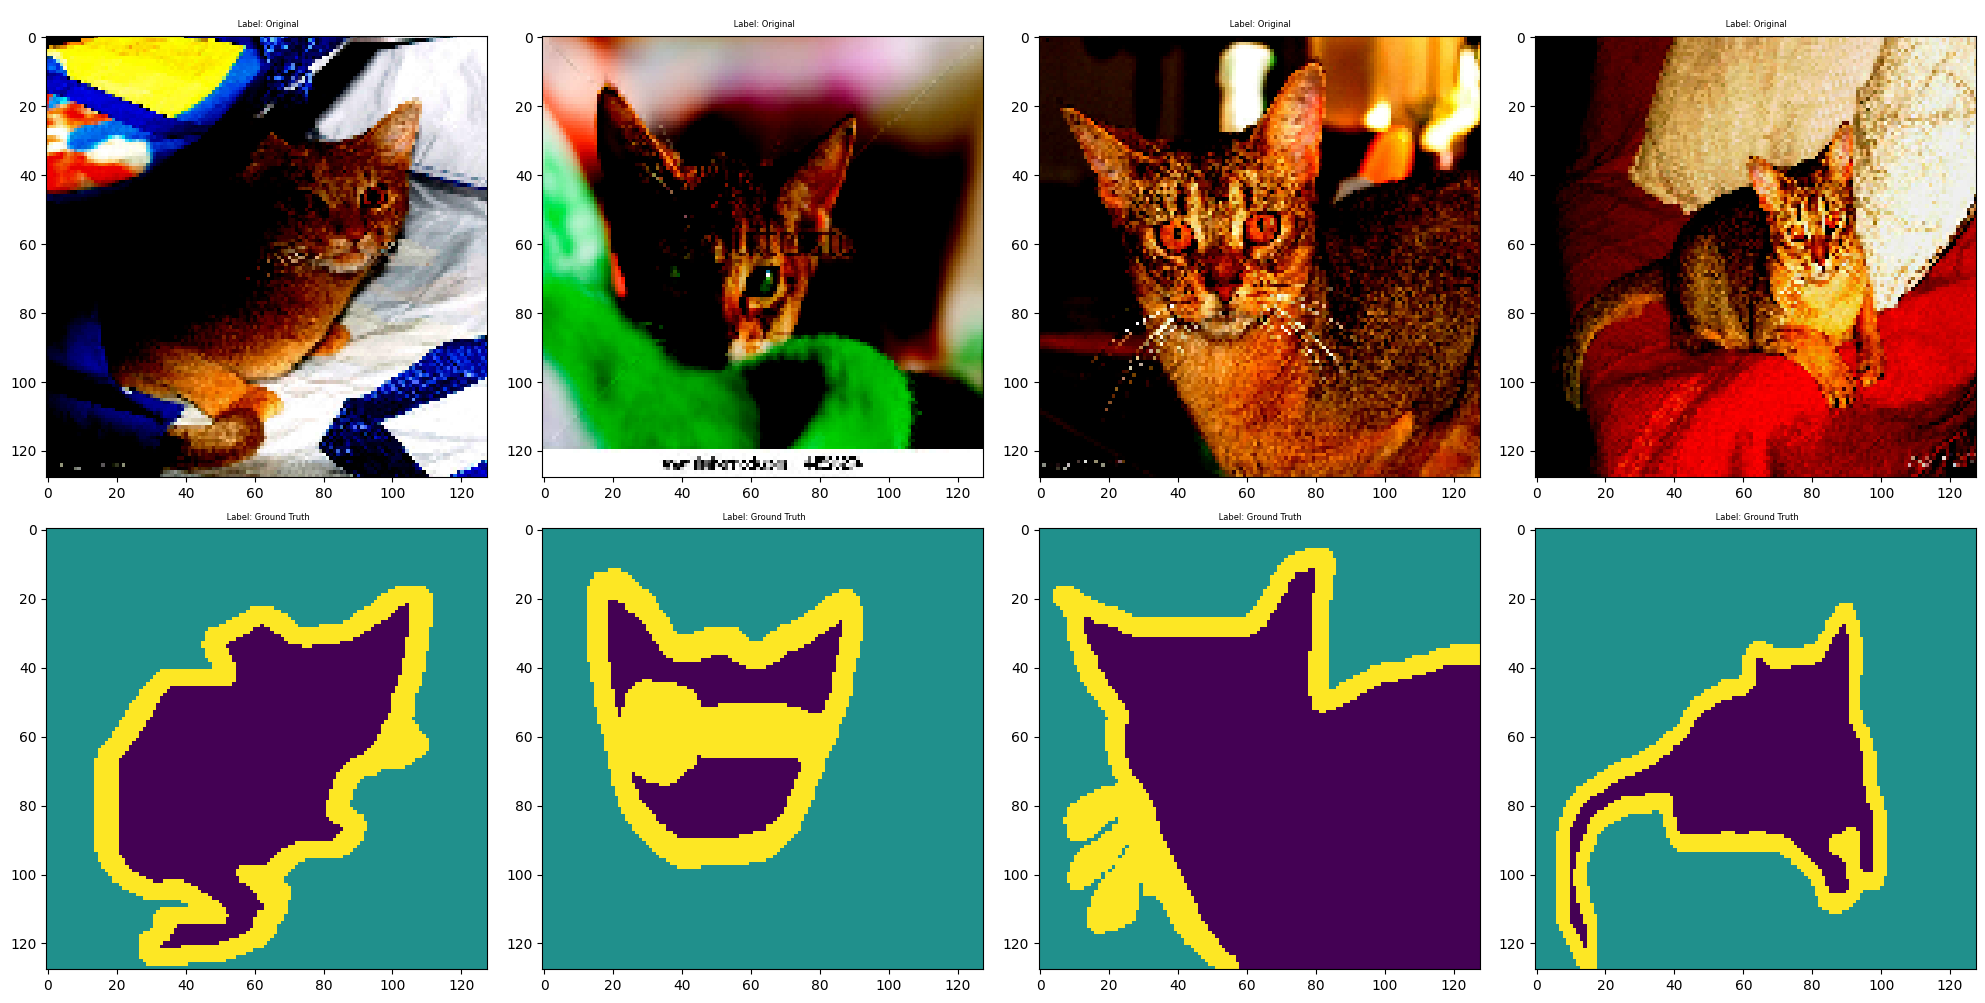

In [3]:
show_sample(trainset)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## MP+Tr+BCE

In [5]:
model = UNet(in_channels = 3, out_channels = 3).to(device)

In [6]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

In [7]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = nn.BCEWithLogitsLoss(),
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:37<00:00,  3.08it/s]

Training Loss: 57.898028165102005


Test set: Average loss=59.21360296010971

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:38<00:00,  3.00it/s]

Training Loss: 39.275745540857315


Test set: Average loss=42.830748468637466

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: 31.837250724434853


Test set: Average loss=29.658504828810692

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: 28.874064594507217


Test set: Average loss=28.06464682519436

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.92it/s]

Training Loss: 26.90036779642105


Test set: Average loss=26.067045778036118

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.94it/s]

Training Loss: 25.092479169368744


Test set: Average loss=24.79764223098755

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: 23.735425636172295


Test set: Average loss=26.813547417521477

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: 22.93260495364666


Test set: Average loss=23.53752888739109

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: 22.16013652086258


Test set: Average loss=23.511479809880257

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.92it/s]

Training Loss: 20.991869926452637


Test set: Average loss=22.17194725573063

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.92it/s]

Training Loss: 20.313602030277252


Test set: Average loss=22.723210334777832

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: 19.345448315143585


Test set: Average loss=22.06530152261257

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: 18.62416408956051


Test set: Average loss=23.47374503314495

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: 18.154343709349632


Test set: Average loss=22.447478398680687

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: 17.038126692175865


Test set: Average loss=20.75004430860281


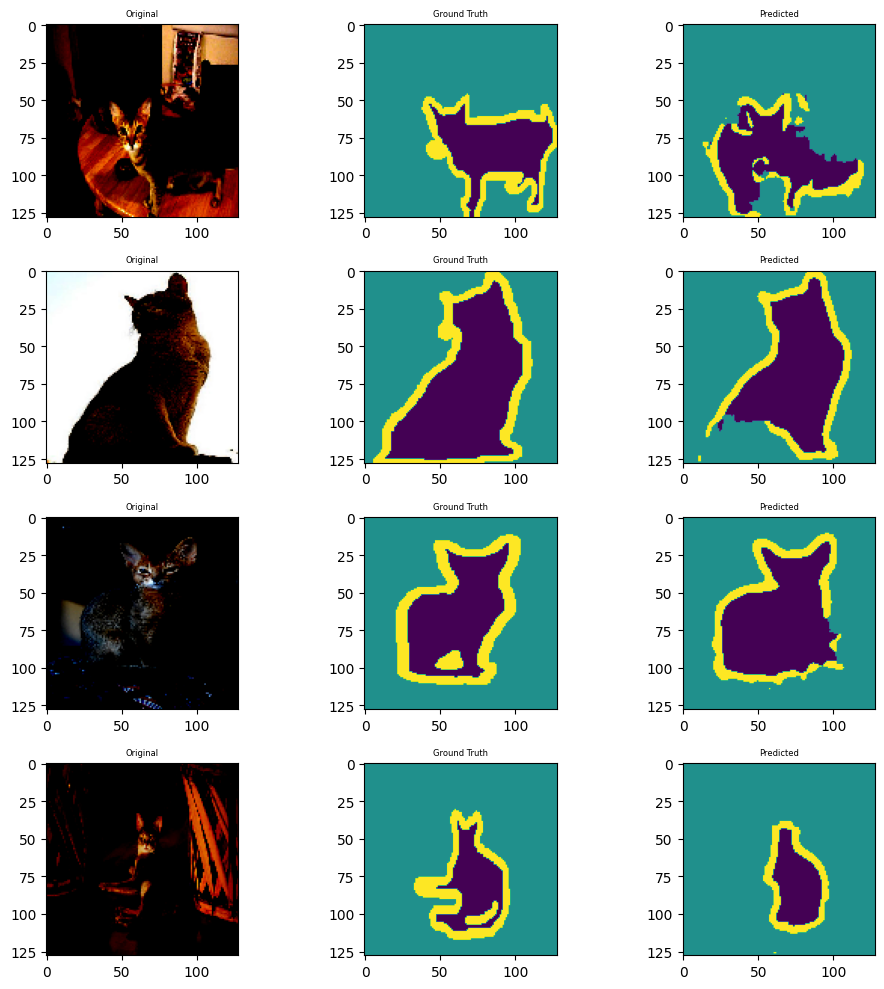

In [9]:
show_sample_output(model,testloader,device,image_no=4)

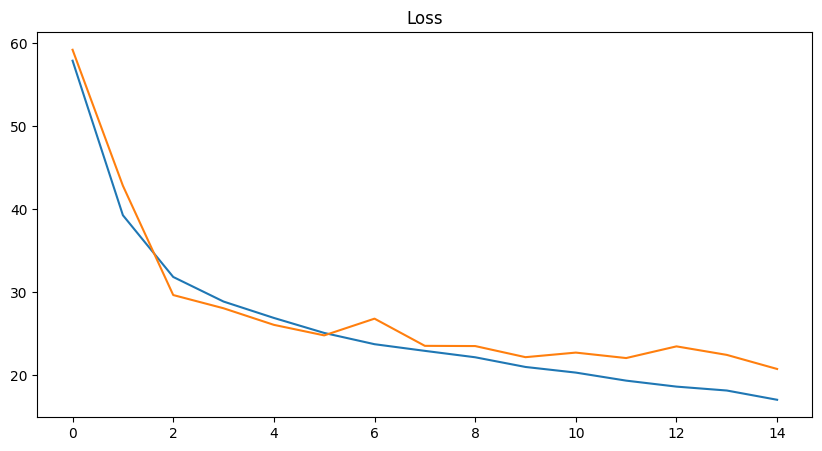

In [10]:
plot_curves(train_losses, test_losses)

## MP+Tr+Dice Loss

In [11]:
model = UNet(in_channels = 3, out_channels = 3).to(device)

In [12]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = unet_dice_loss,
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: -14988.183938145638


Test set: Average loss=-74.22976052761078

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: -3585.0284881591797


Test set: Average loss=6329.501517295837

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.92it/s]

Training Loss: -3984.460178375244


Test set: Average loss=-5440.595603942871

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.94it/s]

Training Loss: -4247.924533843994


Test set: Average loss=-2363.508373260498

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.94it/s]

Training Loss: -4439.253379821777


Test set: Average loss=210.07060050964355

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.94it/s]

Training Loss: -4628.617164611816


Test set: Average loss=249.01873016357422

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.94it/s]

Training Loss: -4791.261848449707


Test set: Average loss=-14728.533610343933

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

Training Loss: -4972.690010070801


Test set: Average loss=-3038.2406272888184

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: -5108.707195281982


Test set: Average loss=-4077.7550802230835

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: -5274.879146575928


Test set: Average loss=-16411.531860351562

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]

Training Loss: -5436.027931213379


Test set: Average loss=-2194.11537361145

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.93it/s]

Training Loss: -5574.092422485352


Test set: Average loss=-1576.4799137115479

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.94it/s]

Training Loss: -5766.529968261719


Test set: Average loss=-6387.144726753235

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.94it/s]

Training Loss: -5912.000782012939


Test set: Average loss=-1709.083327293396

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:39<00:00,  2.94it/s]

Training Loss: -6080.21448135376


Test set: Average loss=2172.098279953003


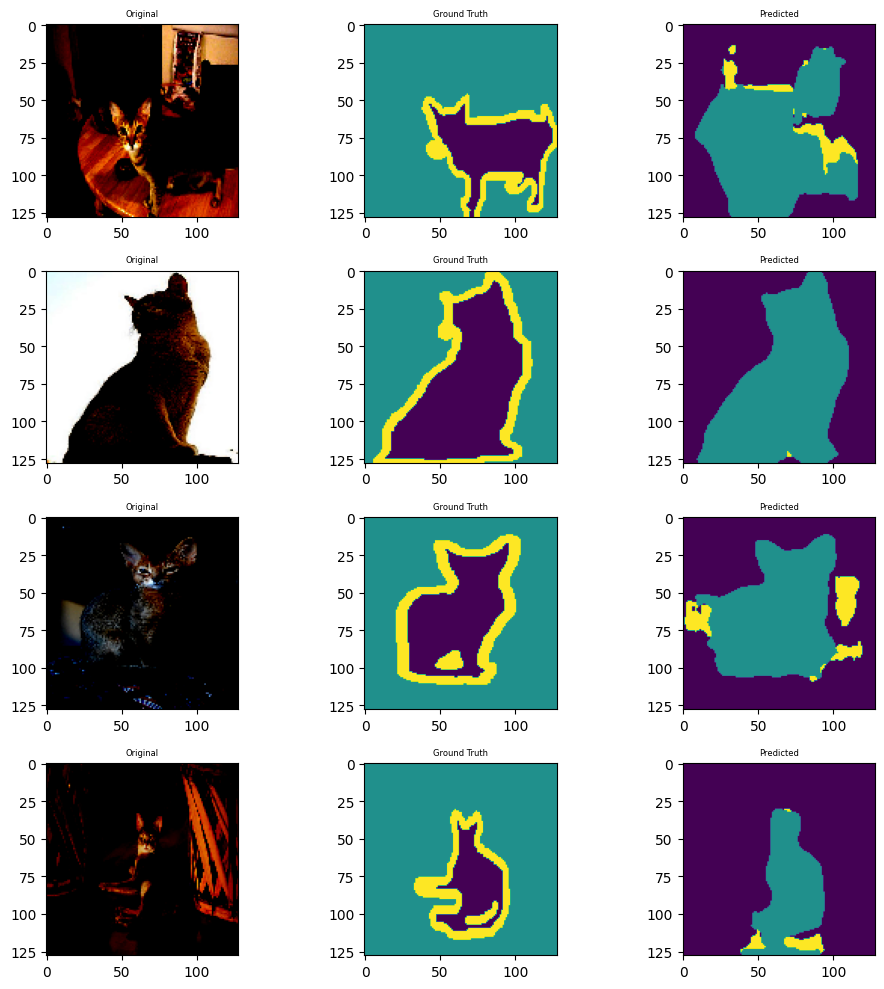

In [14]:
show_sample_output(model,testloader,device,image_no=4)

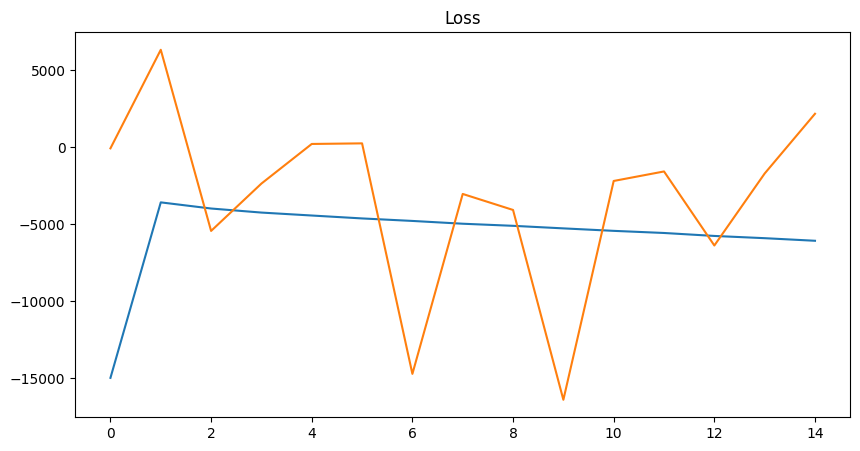

In [15]:
plot_curves(train_losses, test_losses)

## StrConv+Tr+BCE

In [16]:
model = UNet(in_channels = 3, out_channels = 3, pool='StrConv').to(device)

In [17]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

In [18]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = nn.BCEWithLogitsLoss(),
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.83it/s]

Training Loss: 58.572375148534775


Test set: Average loss=94.17986130714417

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.83it/s]

Training Loss: 42.78858470916748


Test set: Average loss=41.9924800992012

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.85it/s]

Training Loss: 35.750930815935135


Test set: Average loss=37.645336642861366

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: 32.191057816147804


Test set: Average loss=29.499892607331276

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: 29.380158185958862


Test set: Average loss=35.46665419638157

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: 27.588099986314774


Test set: Average loss=28.469015330076218

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.83it/s]

Training Loss: 26.66010370850563


Test set: Average loss=27.63331399857998

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: 25.8313190639019


Test set: Average loss=25.681565687060356

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: 24.451588571071625


Test set: Average loss=25.681929126381874

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.83it/s]

Training Loss: 23.784069806337357


Test set: Average loss=24.173929557204247

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: 22.916942417621613


Test set: Average loss=24.039068043231964

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: 22.199568018317223


Test set: Average loss=23.420975409448147

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.82it/s]

Training Loss: 22.00563046336174


Test set: Average loss=24.956779181957245

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.83it/s]

Training Loss: 21.534393817186356


Test set: Average loss=26.75588171184063

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: 20.785470128059387


Test set: Average loss=22.680479526519775


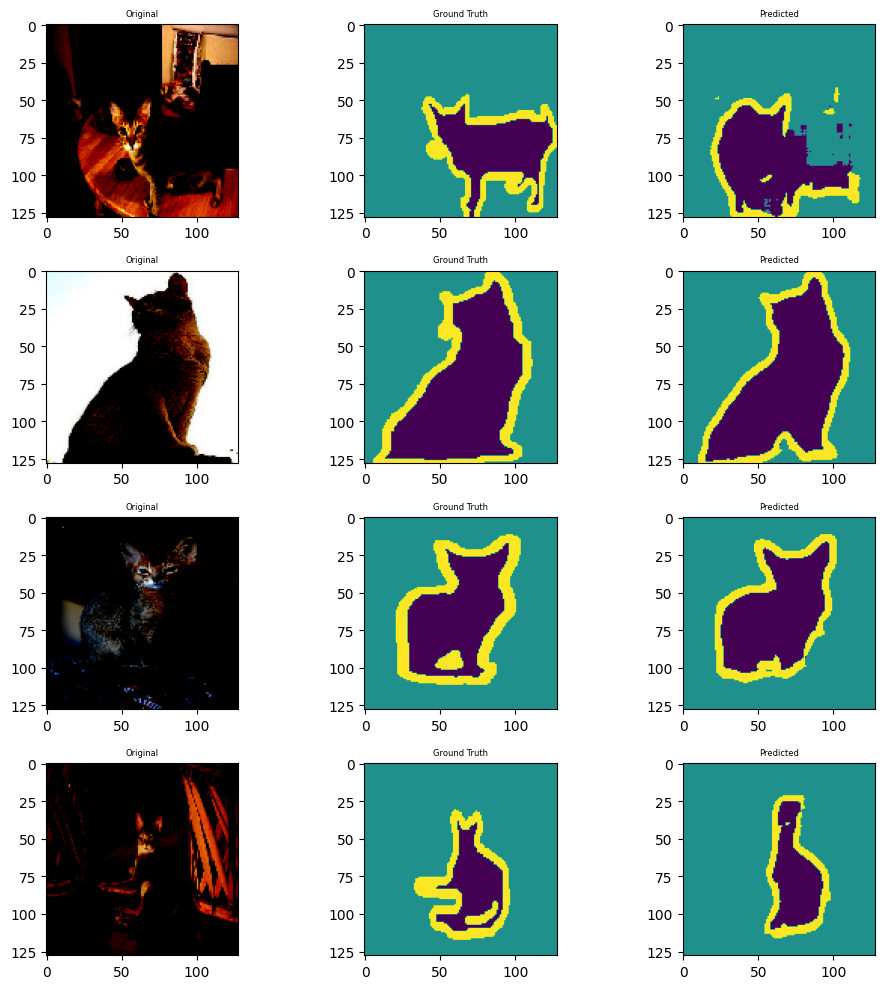

In [20]:
show_sample_output(model,testloader,device,image_no=4)

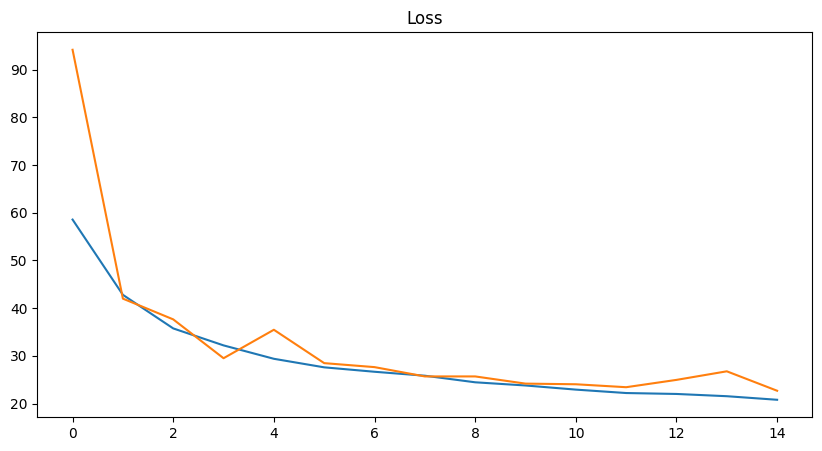

In [21]:
plot_curves(train_losses, test_losses)

## StrConv+Ups+Dice Loss

In [22]:
model = UNet(in_channels = 3, out_channels = 3, mode='upsample', pool='StrConv').to(device)

In [23]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

In [24]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
model, train_losses, test_losses = fit_model_unet(
                                                model=model,
                                                device=device,
                                                trainloader=trainloader,
                                                testloader=testloader,
                                                criterion = unet_dice_loss,
                                                EPOCHS=15,
                                                optimizer=optimizer,
                                            )


 EPOCH: 1 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -2260.9181845784187


Test set: Average loss=10827.439171791077

 EPOCH: 2 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.85it/s]

Training Loss: -3416.9540100097656


Test set: Average loss=2041.7259950637817

 EPOCH: 3 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.83it/s]

Training Loss: -5187.545337677002


Test set: Average loss=29367.897102355957

 EPOCH: 4 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -4349.939970493317


Test set: Average loss=-1589.1722502708435

 EPOCH: 5 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -2058.6840314865112


Test set: Average loss=-82.11089992523193

 EPOCH: 6 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -2350.4616355895996


Test set: Average loss=3493.6149005889893

 EPOCH: 7 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -2578.0293922424316


Test set: Average loss=-15874.881034851074

 EPOCH: 8 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.82it/s]

Training Loss: -2778.583818435669


Test set: Average loss=-2631.0340089797974

 EPOCH: 9 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -2992.2215309143066


Test set: Average loss=9281.859058380127

 EPOCH: 10 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -3252.032434463501


Test set: Average loss=39236.94672584534

 EPOCH: 11 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.82it/s]

Training Loss: -3537.6160373687744


Test set: Average loss=-3782.1420402526855

 EPOCH: 12 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -3852.7009601593018


Test set: Average loss=-8070.650800704956

 EPOCH: 13 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -4294.752021789551


Test set: Average loss=-12224.882089614868

 EPOCH: 14 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.84it/s]

Training Loss: -4895.907039642334


Test set: Average loss=-1885.42604637146

 EPOCH: 15 (LR: 0.001)


100%|██████████| 115/115 [00:40<00:00,  2.83it/s]

Training Loss: -5748.875831604004


Test set: Average loss=-1145.6378135681152


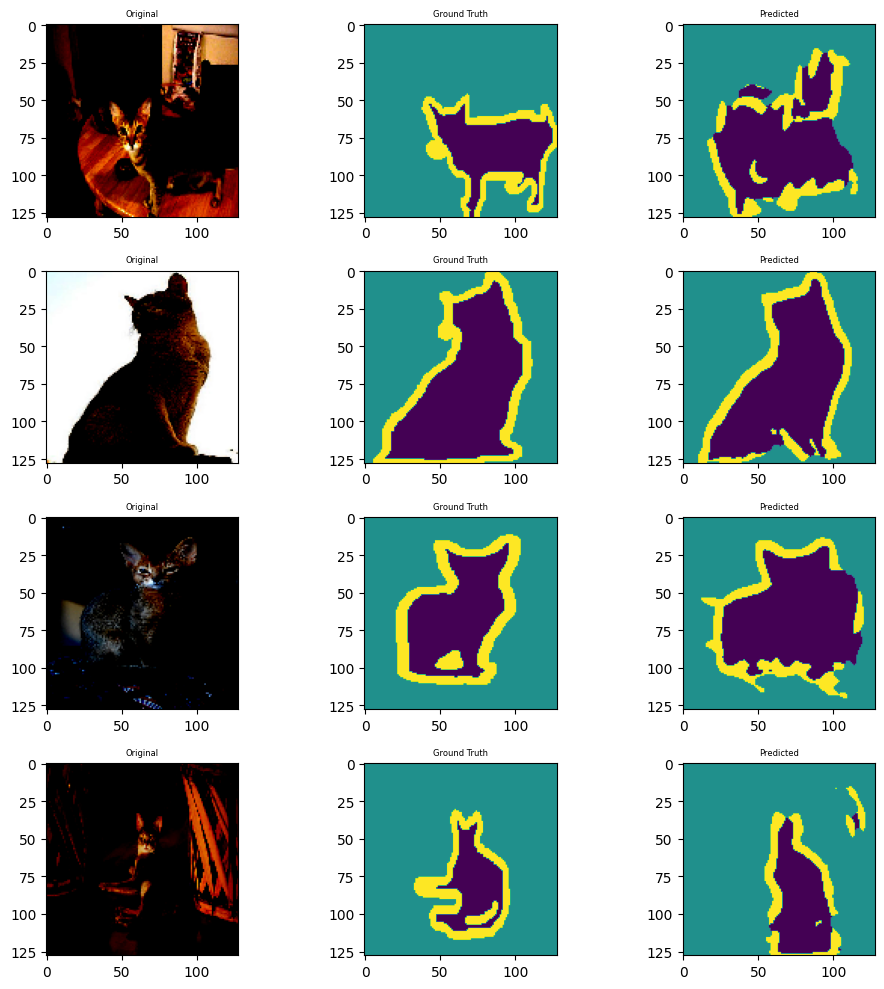

In [26]:
show_sample_output(model,testloader,device,image_no=4)

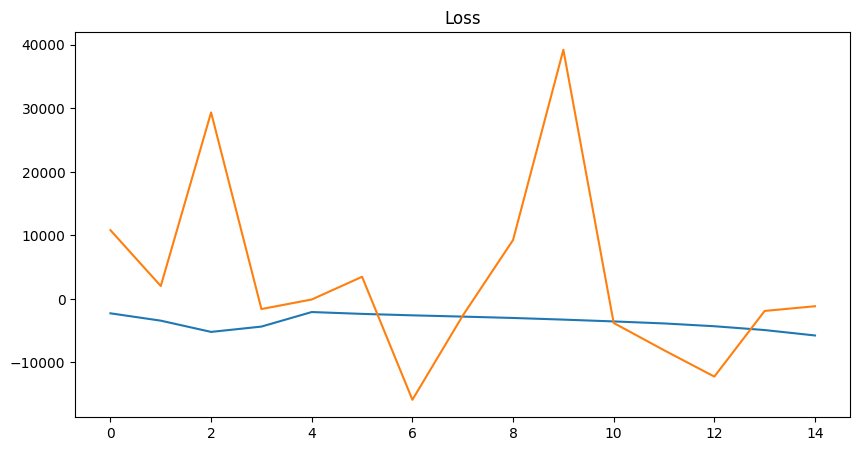

In [27]:
plot_curves(train_losses, test_losses)